# P2 submission

---

**Requirements**
P2 submission notebook should show :
- That you can handle the data in its size.
- That you understand what’s in the data (formats, distributions, missing values, correlations, etc.).
- That you considered ways to enrich, filter, transform the data according to your needs.
- That you have a reasonable plan and ideas for methods you’re going to use, giving their essential mathematical details in the notebook.
- That your plan for analysis and communication is reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.



**Project proposal**

Best breweries in the world 

The idea behind the identification of the best breweries is that the consumer might be more interested to try new and/or original products that come from a good brewery. This ranking is based on the ratings given by the tasters, but the ratings have to be weighted by the number of ratings for the best beers, the quality and emotions transmitted in the text following the different ratings. Some ratings might be biased or unclear so some of them might have to be filtered. Once the ranking is determined a visualisation is to be created to convey properly the attributes of the best breweries (number of “quality” beers, rankings by styles).

*Feedback*

Find and visualize the best breweries - clarity: 75 - creativity: 75 - feasibility: 75, using beer-level reviews as a proxy for brewery reviews is doable, yet will require detailed analysis. 

---

# Beer reviews EDA

This dataset consists of beer reviews from two Beer rating websites: BeerAdvocate and RateBeer, for a period of 17 years ranging from 2001 to 2017.

Metadata about users, beers, and breweries (CSV)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import os
import spacy

# Handle size of the data

### Load ratings.txt

In [9]:
def load_txt_file(website):
    if website == 'BeerAdvocate':
        # Specify the directory containing the text files
        directory = './../dataset_BeerReviews/BeerAdvocate/rates_comp/'
    else:
        directory = './../dataset_BeerReviews/RateBeer/rates_comp/'

    # Initialize an empty list to store DataFrames
    dfs = []

    # Loop through the files in reverse order (ratings-5.txt to ratings-1.txt)
    for i in range(1, 0, -1):
        file_name = f'ratings-{i}.txt'
        file_path = os.path.join(directory, file_name)

        with open(file_path, 'r') as f:
            text = f.read()

        # Remove double quotes at the beginning of each line
        data = re.sub('"', '', text)
        data = re.sub(r'^"', '', data, flags=re.MULTILINE)

        # Split the text into individual beer reviews
        beer_reviews = data.split('beer_name')

        # Extract the beer information from each review
        beer_data = []
        for review in beer_reviews:
            beer_info = {}
            for line in [entry.split(':', 1) for entry in review.split('\n') if ':' in entry]:# and 'text' not in entry]:
                if line:  # Check if the list is not empty
                    key, value = line[0].strip(), line[1].strip()
                    beer_info[key] = value
            beer_data.append(beer_info)

        # Convert the beer data into a DataFrame
        df = pd.DataFrame(beer_data)

        # Append the DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    final_df = pd.concat(dfs, ignore_index=True)

    # Rename the columns
    final_df.columns = [
        'beer_name',
        'beer_id',
        'brewery_name',
        'brewery_id',
        'style',
        'abv',
        'date',
        'user_name',
        'user_id',
        'appearance',
        'aroma',
        'palate',
        'taste',
        'overall',
        'rating',
        'text']
    
    # sample the data
    df_sampled = final_df.sample(frac = 0.5, random_state=42)
    # convert columns with numerical values to int or float
    
    return df_sampled

ratings_BA = load_txt_file('BeerAdvocate')
#ratings_RB = load_data_from_txt('RateBeer')

In [16]:
ratings_BA.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
262500,Brew Brothers Prairie Berry Ale,21927,Brew Brothers Brewing &#40;Alberta&#41;,3033,Fruit Beer,5.5,1044615600,presario,5348,3,6,3,7,13,3.20,Big blue 1L bottle. Very loud pop announced t...
39881,Ed Hardy Premium Beer,110849,Cervecería Mexicana (Grupo Modelo),5973,Pale Lager,4.6,1281520800,Cajun,47922,2,4,2,3,5,1.60,Tasting - Gulf Brew 2010 - Pale amber white he...


### Load the other data

In [8]:
# BeerAdvocate
beers_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/beers.csv")
breweries_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/breweries.csv")
users_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/users.csv")

# RateBeer
beers_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/beers.csv")
breweries_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/breweries.csv")
users_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/users.csv")

# matched_beer_data
beers_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/beers.csv", header=1)
breweries_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/breweries.csv", header = 1)
ratings_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/ratings.csv", header=1)
users_approx = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users_approx.csv", header=1)
users_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users.csv", header=1)

## EDA

Do univariate and multivariate analysis


- formats
- distributions
- missing values
- correlations
- etc...

In [17]:
users_BA.dtypes

nbr_ratings      int64
nbr_reviews      int64
user_id         object
user_name       object
joined         float64
location        object
dtype: object

In [5]:
def get_feature_stats(df):
    """
    Obtains descriptive statistics for all features and percentage of missing 
    values
    
    Parameters
    ----------
    df : DataFrame
         Containing all data

    Returns
    -------
    stats : DataFrame
            Containing the statistics for all features.
                   
    """
    ### BEGIN SOLUTION
    numerical = df.describe(include= ['float64', 'int64'])
    categorical = df.describe(include= ['object'])
    stats = pd.concat([numerical, categorical])
    #stats = df.describe(include= 'all') # alternative
    
    # Select the desired statistics
    stats = stats.loc[['mean', 'std', '50%', 'unique', 'top', 'freq']]
    percentage = df.isnull().sum(axis = 0)*100 / len(df)
    stats.loc['missing_values'] = np.array(percentage)
    ### END SOLUTION
    return stats

beers_BA_stats = get_feature_stats(beers_BA)
beers_BA_stats

,beer_id,brewery_id,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,beer_name,brewery_name,style
mean,148556.817141,21335.895860,29.887267,9.221417,3.721034,84.633284,84.806559,6.491370,3.717594,-0.408295,1.029207,3.747771,NaN,NaN,NaN
std,84307.593397,15385.715656,231.010063,68.866445,0.476003,4.052723,10.507735,2.054071,0.464248,0.806491,17.295308,0.484775,NaN,NaN,NaN
50%,148867.000000,24075.000000,2.000000,1.000000,3.780000,85.000000,87.000000,6.000000,3.770000,-0.321596,0.000000,3.808333,NaN,NaN,NaN
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236209,14098,104
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oktoberfest,Rock Bottom Restaurant & Brewery,American IPA
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,577,1219,30433
missing_values,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.690282,78.206913,97.969540,12.828009,11.694555,85.654665,0.0,89.932449


In [12]:
users_BA.head()

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland


['nbr_ratings', 'nbr_reviews', 'joined']
['user_name', 'user_id', 'location']
avt isna
apres isna
avt isna
apres isna
avt isna
apres isna
avt isna
apres isna
avt isna
apres isna
avt isna
apres isna


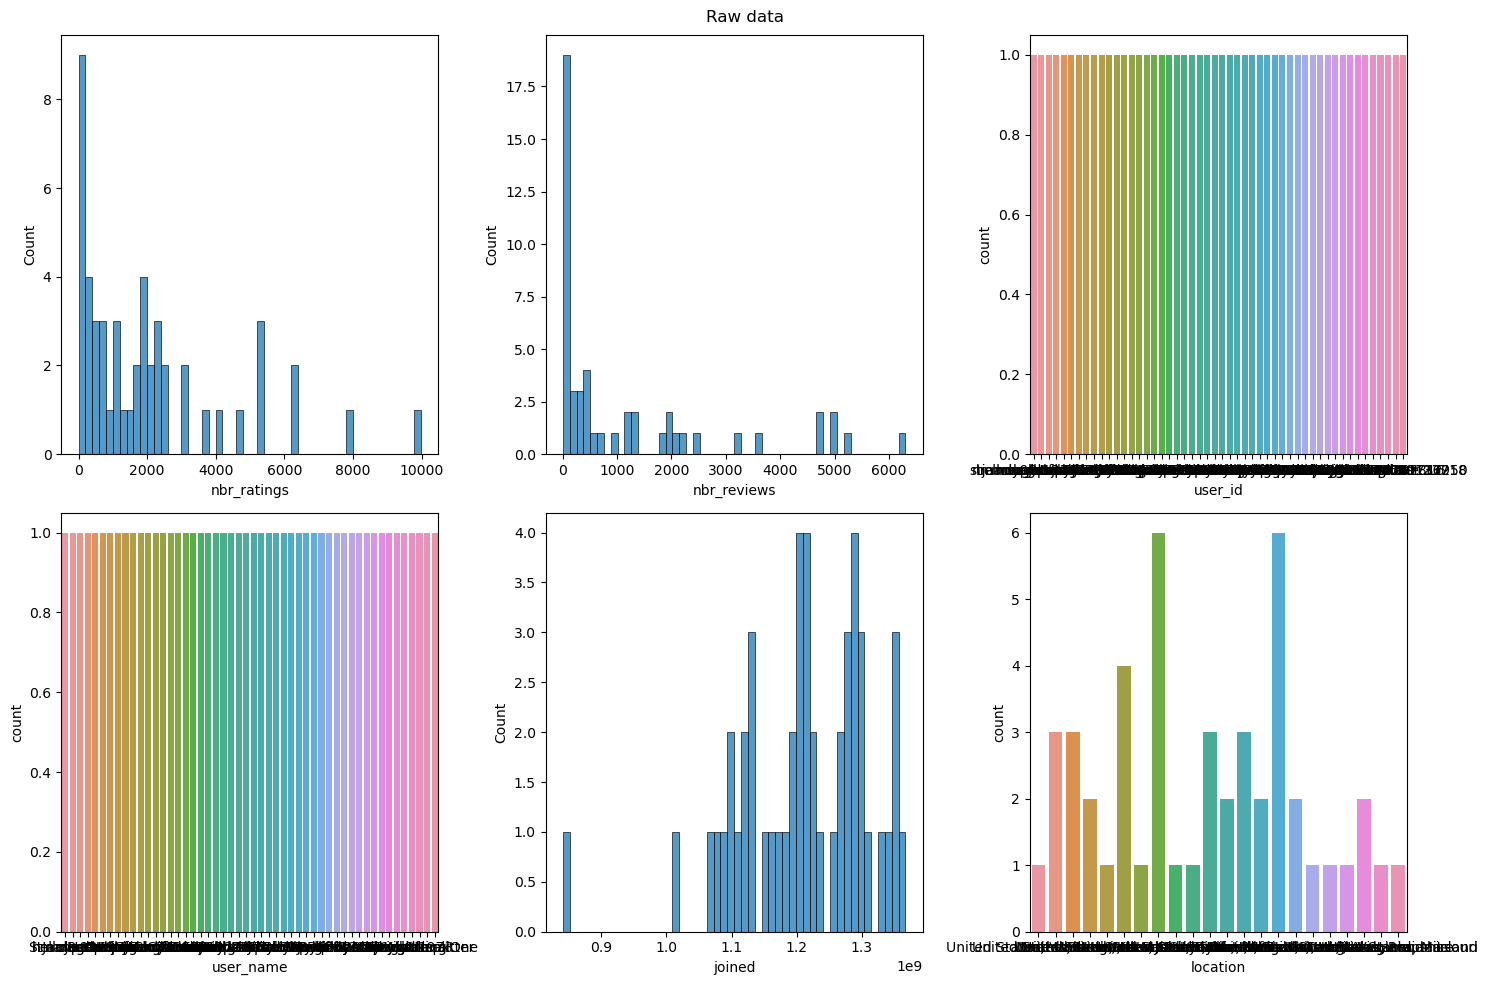

In [14]:
### 1.3
def plot_features(df, title):
    continuous_cols = list(df._get_numeric_data().columns)
    print(continuous_cols)
    categorical_cols = list(set(df.columns) - set(continuous_cols))
    print(categorical_cols)
    fig, axes = plt.subplots(2, 3, figsize=(15,10))
    for i, col in enumerate(df.columns):
        ax = axes[i // 3, i % 3]
        print("avt isna")
        data = df[~df[col].isna()]
        print("apres isna")
        if col in continuous_cols:
            sns.histplot(data=data[col], bins=50, ax=ax) #Filter out nan values in the features
        elif col in categorical_cols:
            sns.countplot(data=data, x=col, ax=ax)
        else:
            print(col)
    fig.suptitle(title)
    fig.tight_layout()
    
    return plt
    
plot_features(users_BA.iloc[:50],"Raw data")
plt.show()


## Data preprocessing

- enrichment
- filtering
- transformation

In [ ]:
# todo

## Feasibility check of project's methods
- give their essential mathematical details in the notebook.

In [ ]:
# todo

## Alternatives considered
- analysis and communication is reasonable

In [ ]:
# todo